<a href="https://colab.research.google.com/github/nilakshi104/Basic-Transformer-Model/blob/main/Using%20torchtext.datasets.Multi30k.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torchtext==0.6.0 #run this cell & restart to avoid error while using bleu_score

     |████████████████████████████████| 71kB 6.0MB/s 
     |████████████████████████████████| 1.2MB 15.0MB/s 
  Found existing installation: torchtext 0.3.1
    Uninstalling torchtext-0.3.1:
      Successfully uninstalled torchtext-0.3.1


In [2]:
#Pytorch Libraries
import torch
import torch.nn as nn
import torch.optim as optim

#torchtext package consists of data processing utilities and popular datasets for natural language.
import torchtext
from torchtext.datasets import Multi30k
from torchtext.data import Field, BucketIterator

#Plotting graphs
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

#To tokenize sentence using spacy models
import spacy

import numpy as np

import random
import math
import time

In [3]:
#to reproduce results
SEED=1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

#Downloading spacy models

In [4]:
!python -m spacy download de
!python -m spacy download en

     |████████████████████████████████| 14.9MB 1.2MB/s 
  Created wheel for de-core-news-sm: filename=de_core_news_sm-2.2.5-cp36-none-any.whl size=14907057 sha256=37772c2f1563d5c405252f2bad1cd01b21c8f1e2585d87a689b6e6d0a43acc84
  Stored in directory: /tmp/pip-ephem-wheel-cache-45gizyfj/wheels/ba/3f/ed/d4aa8e45e7191b7f32db4bfad565e7da1edbf05c916ca7a1ca
Successfully built de-core-news-sm
✔ Download and installation successful
You can now load the model via spacy.load('de_core_news_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/de_core_news_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/de
You can now load the model via spacy.load('de')
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


#Load Tokenizer for English and German Language

In [5]:
spacy_de = spacy.load('de')
spacy_en = spacy.load('en') 

#Let's see how Spacy tokenizes different sentences

In [6]:
s1='Apple is looking at buying U.K. company which is two-three years old for $1 billion'
s2='10km cab ride almosts cost $20 in india so you\'ll go by cab'
s3='Hello all, We are here to help you!Email us at iv@gmail.com or visit us at iv.com'
s4="Let's watch 'movie' together"

s1_token=[tok.text for tok in spacy_en.tokenizer(s1)]
s2_token=[tok.text for tok in spacy_en.tokenizer(s2)]
s3_token=[tok.text for tok in spacy_en.tokenizer(s3)]
s4_token=[tok.text for tok in spacy_en.tokenizer(s4)]
print('S1_token {0}'.format(s1_token))

print('\n1. U.K. is considered as same word \n2. two-three is separated into three words properly instead of considering as one combined word \n3.$1 is sepaarated into two words')

print('\nS2_token {0}'.format(s2_token))

print('\n1. 10km is considered as separate word \n2.same goes with $20 \n3.you\'ll is separated properly as you + \'ll')

print('\nS3_token {0}'.format(s3_token))

print('\n1.words are not blindly splitted by considering space so all, are splitted as all+, \n2.iv@gmail.com is considered as single word instead of splitting it into different words\n3. Same goes with iv.com')

print('\nS4_token {0}'.format(s4_token))

print('\n1.Let\'s is tokenized into Let and \'s\n2.\'movie\' is splitted as \' + movie +\'')

S1_token ['Apple', 'is', 'looking', 'at', 'buying', 'U.K.', 'company', 'which', 'is', 'two', '-', 'three', 'years', 'old', 'for', '$', '1', 'billion']

1. U.K. is considered as same word 
2. two-three is separated into three words properly instead of considering as one combined word 
3.$1 is sepaarated into two words

S2_token ['10', 'km', 'cab', 'ride', 'almosts', 'cost', '$', '20', 'in', 'india', 'so', 'you', "'ll", 'go', 'by', 'cab']

1. 10km is considered as separate word 
2.same goes with $20 
3.you'll is separated properly as you + 'll

S3_token ['Hello', 'all', ',', 'We', 'are', 'here', 'to', 'help', 'you!Email', 'us', 'at', 'iv@gmail.com', 'or', 'visit', 'us', 'at', 'iv.com']

1.words are not blindly splitted by considering space so all, are splitted as all+, 
2.iv@gmail.com is considered as single word instead of splitting it into different words
3. Same goes with iv.com

S4_token ['Let', "'s", 'watch', "'", 'movie', "'", 'together']

1.Let's is tokenized into Let and 's
2.'mo

In [7]:
def tokenize_de(text):
    
    # Tokenizes German text from a string into a list of strings
    
    return [tok.text for tok in spacy_de.tokenizer(text)]

def tokenize_en(text):
    
    # Tokenizes English text from a string into a list of strings
  
    return [tok.text for tok in spacy_en.tokenizer(text)]

In [8]:
#Field class performs data processing like tokenization, lower casing of words in sentence
SRC=Field(tokenize=tokenize_de,
          init_token='<sos>',
          eos_token='<eos>',
          lower=True,  #Whether to lowercase the text in field.
          batch_first=True)  #since model expects - tensors with batch_dimension first

TRG=Field(tokenize=tokenize_en,
          init_token='<sos>',
          eos_token='<eos>',
          lower=True,
          batch_first=True)

In [9]:
train_data, valid_data, test_data = Multi30k.splits(exts=('.de','.en'),
                                                    fields=(SRC,TRG))

#while writing exts and fiels source and target info should be written in arc+trg order

downloading training.tar.gz


training.tar.gz: 100%|██████████| 1.21M/1.21M [00:02<00:00, 527kB/s]


downloading validation.tar.gz


validation.tar.gz: 100%|██████████| 46.3k/46.3k [00:00<00:00, 173kB/s]


downloading mmt_task1_test2016.tar.gz


mmt_task1_test2016.tar.gz: 100%|██████████| 66.2k/66.2k [00:00<00:00, 167kB/s]


In [10]:
print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 29000
Number of validation examples: 1014
Number of testing examples: 1000


In [11]:
print(vars(train_data.examples[0])['trg'])

['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']


In [12]:
#FUNC TO GET LIST OF ALL SUBCLASSES FROM CLASS
# for child in train_data.__bases__():
#   print('j')

In [13]:
SRC.build_vocab(train_data, min_freq = 2) #Words having frequency less than min_freq are replaced by <unk> token so token that appear atleast min_freq times are only allowed
TRG.build_vocab(train_data, min_freq = 2)

In [14]:
print(f"Unique tokens in source (de) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

Unique tokens in source (de) vocabulary: 7855
Unique tokens in target (en) vocabulary: 5893


In [16]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

Next step is to create batches using iterators for that we need to check if sentences are padded properly or not in batches here torchtext iterator handles all these things

Will use BucketIterator instead of standard Iterator as Bucketiterator makes sure that sentences with same length comes under one batch so minimum padding is needed

In [17]:
BATCH_SIZE=128

#BucketIterator splits data into batches
train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data,valid_data,test_data),
    batch_size=BATCH_SIZE,
    device=device   
)

In [19]:
# help(BucketIterator)
train_iterator
valid_iterator

#1. Feeding Input Tokens and Position Encodings :

### Position Embedding:

* Unlike RNN, CNN model, transformer model doesnt have any knowlege about position of words in sentences as all the words in sentence are processsed parallely at same time. So to add knowledge about position in model, Positional Embeddings are used. 

### In BERT model, learned positional embeddings are used. 

* Considering dim of embedding layer = [vocab length, embd dim] and positional embedding layer =    [max_sent_length,embd_dim] 

* Here length of second dim in both is same because both embeddings needs to be added and then fed as input

* Here maximum length of sentence is considered as 100 so model can handle sentence length upto 100 words in both training and testing.

### In Basic transformer Model (Attention is all You need paper), Static Embeddings are used that includes use of sine and cosine.

* One advantage of static emb over learned positional embedding is that static emb can easily extrapolate to longer sentences than the one encountered during training.

* $PE_{pos,2i}$ = sin($pos/10000^{2i/dmodel}$)

* $PE_{pos,2i+1}$ = cos($pos/10000^{2i/dmodel}$)

Where pos is position and i is dimension. That is each dimension of positional encoding corresponds to sine wave.

`The wavelengths form a geometric progression from 2π to 10000⋅2π. We chose this function because we hypothesized it would allow the model to easily learn to attend by relative positions, since for any fixed offset k, PEpos+k can be represented as a linear function of PEpos.`

As this is static positional embedding, will set require_grad= False while defining the variable for it.


##**Understanding Positional Embeddings**

As the transformer model diteched RNN, CNN mechanism some positional encoding needs to be fed into it additionally.

* Possibility1 - Is it to assign values between [0,1] to all words in sentence. But in this case probelm will be delta between succesive time steps(word) will not be same. So if sent is small, delta will be more and viceversa

*Possibility2 - assigning token according to position of word in sent like 1 for first sent, 2 for second sent etc. But in this case number will become large for longer sentences and it might happen that will encunter sent longer than the training samples.

* following condition needs to be Considered:

1.It should output a unique encoding for each time-step (word’s position in a sentence)

2.Distance between any two time-steps should be consistent across sentences with different lengths.

3.Our model should generalize to longer sentences without any efforts. Its values should be bounded.
    
4.It must be deterministic.

#**Proposed Method**

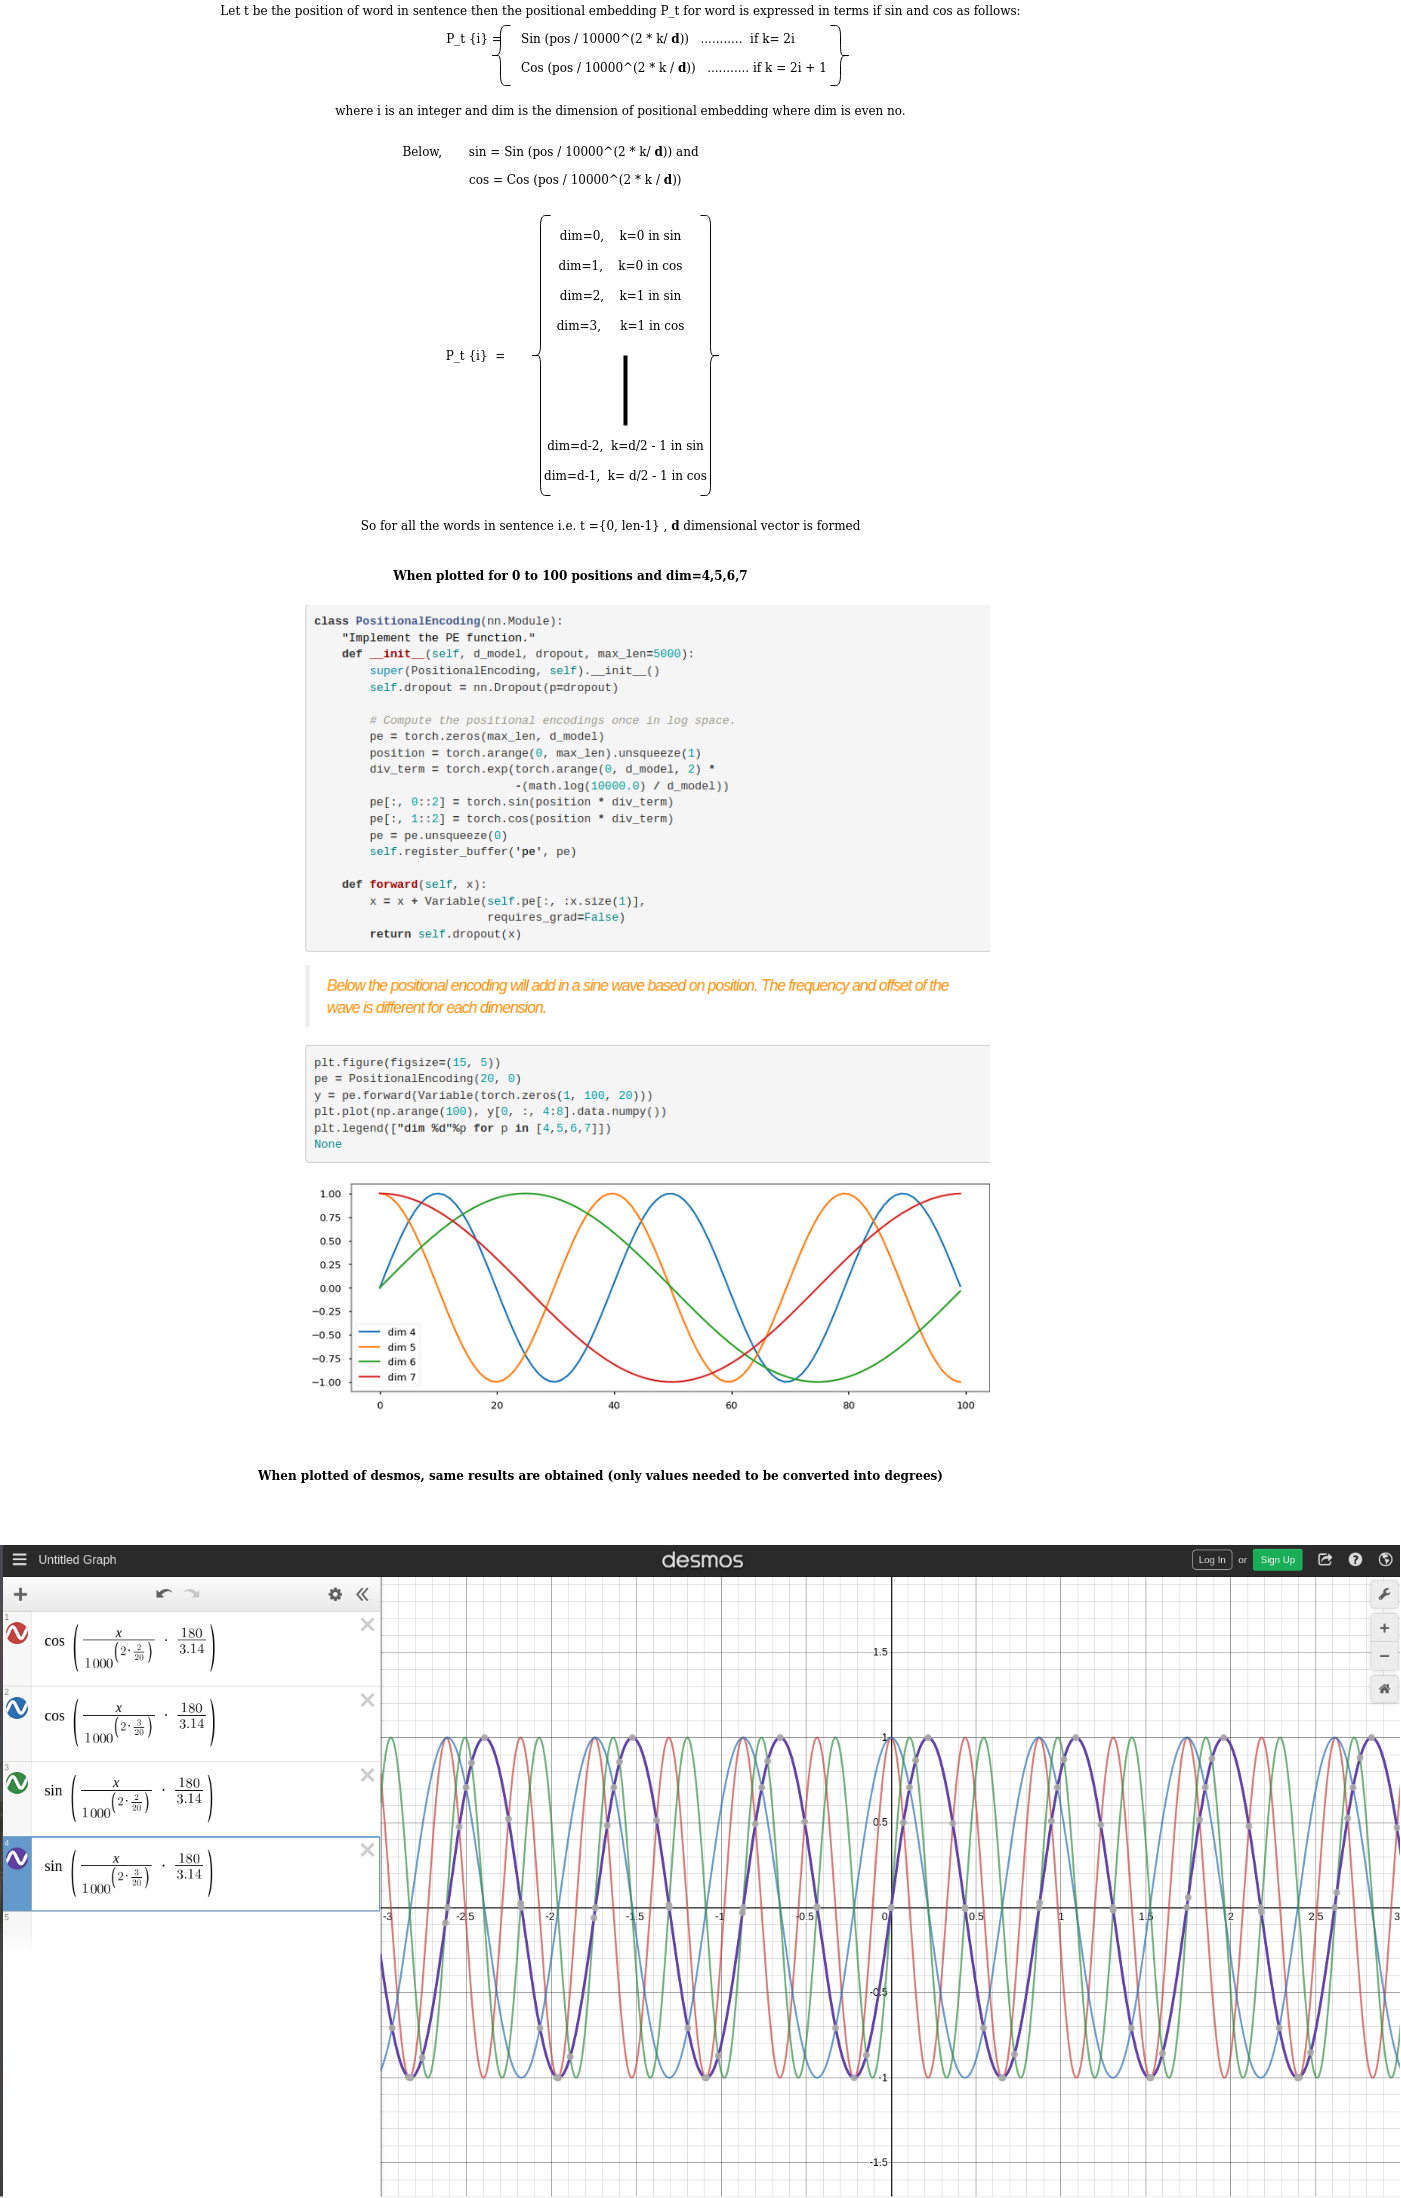



##But in this nb will use learned positional embeddings as same is used in BERT

##2. ENCODER

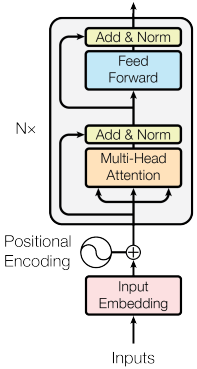



In [20]:
class Encoder(nn.Module):
  def __init__(self,
               input_dim,  #vocabulary size
               hid_dim, #second dimension of standard embedding and positional embedding = hid_dim
               n_layers,  #no. of layers of encoder =6 (from paper)
               n_heads,   # no. of heads in multihead = 8 (from ppr)
               pf_dim,  #For positionwise_feedforward layer
               dropout,   # 0.1 (from ppr)
               device,
               max_length=100): #Max 100 words are allowed in sentence

    super().__init__()

    self.device=device
    self.tok_embedding=nn.Embedding(input_dim,hid_dim)
    self.pos_embedding=nn.Embedding(max_length,hid_dim)
    self.layers=nn.ModuleList([EncoderLayer(hid_dim,
                                            n_heads,
                                            pf_dim,
                                            dropout,
                                            device)
                              for _ in range(n_layers)])
    self.dropout=nn.Dropout(dropout)
    self.scale=torch.sqrt(torch.FloatTensor([hid_dim])).to(device)  #WHY TO(DEVICE)??????

  def forward(self,src,src_mask):

    #src =[ batch size, src_len]
    #src_mask=[batch_size,1,1,src_len]  ...In later steps src_mask is applied on energy of dim=[batch_size,n_heads,query_len,src_len] so aacordingly new dim are added in src_mask 

    batch_size= src.shape[0]
    src_len =src.shape[1]

    pos=torch.arange(0,src_len).unsqueeze(0).repeat(batch_size,1).to(self.device)

    # pos = tensor([0,1,2,3-----------,src_len-1],
    #              [0,1,2,3-----------,src_len-1],
    #              [0,1,2,3-----------,src_len-1],
    #              [0,1,2,3-----------,src_len-1],
    #              [0,1,2,3-----------,src_len-1])

    # pos = [batch_size, src_len]

    # Before adding std embedding to pos embedding, std embd are multiplied by sqrt(hid_dim) this supposedly reduces variance in the embeddings and model is difficult to train reliably without this scaling factor. 
    #after adding sqrt(hid_dim)*std_embd to pos_embd, dropout is applied to addition

    src = self.dropout((self.tok_embedding(src)*self.scale)+self.pos_embedding(pos))
    #src = [batch_size,src_len,hid_dim]

    # Different parameters are used in each layer
    for layer in self.layers:
      src=layer(src,src_mask)
    #src=[batch_size,src_len,hid_dim]

    return src

In [21]:
class EncoderLayer(nn.Module):
  def __init__(self,
               hid_dim,
               n_heads,
               pf_dim,
               dropout,
               device):
    
    super().__init__() #To reuse base state. Refer this : https://www.youtube.com/watch?v=tX_v8dgb_7I

    self.self_attn_layer_norm = nn.LayerNorm(hid_dim) # normalizes the values of the features, i.e. across the hidden dimension, so each feature has a mean of 0 and a standard deviation of 1. This allows neural networks with a larger number of layers, like the Transformer, to be trained easier.
    self.ff_layer_norm = nn.LayerNorm(hid_dim)
    self.self_attention = MultiHeadAttentionLayer(hid_dim,n_heads,dropout,device)
    self.positionwise_feedforward=PositionwiseFeedforwardLayer(hid_dim,pf_dim,dropout)
    self.dropout=nn.Dropout(dropout)

  def forward(self,src,src_mask):

    #src = [batch_size,src_len,hid_dim]
    #src_mask = [batch_size,1,1,src_len]   ....It is then unsqueezed so it can be correctly broadcast when applying the mask to the energy

    #self_attention
    _src,_ = self.self_attention(src,src,src,src_mask)

    #dropout is applied on output from self_attention i.e. _src and then src is added followed by layer normalization
    src = self.self_attn_layer_norm(src + self.dropout(_src))
    #src =[batch_size, src_len, hid_dim]

    #positionwise feedforward
    _src = self.positionwise_feedforward(src)

    src = self.ff_layer_norm(src + self.dropout(_src))

    #src = [batch_size,src_len,hid_dim]

    return src


##MultiHead Attention

Why Multihead Attention???

Each Head in MultiHead Attention is used to learn different specifics of word e.g. one head will learn semantics, other head will learn grammar, third head will learn dependencies like this total 8 heads are used in paper.

Hidden dimension is split into 8 parts and each is fed as input to multihead attention. After sending through all layers, Multihead outputs are concatenated to form hid_dim

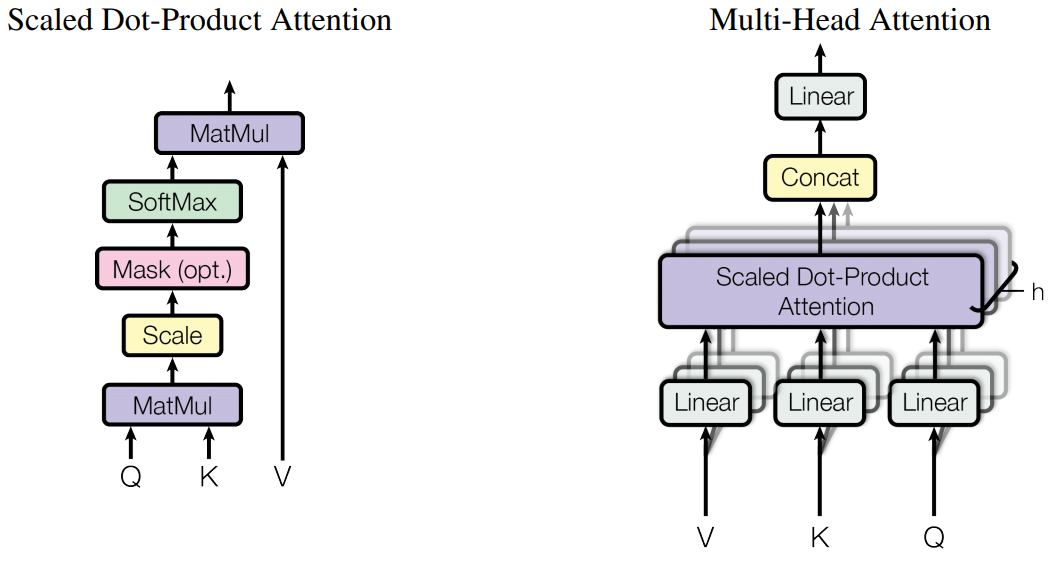

In [22]:
class MultiHeadAttentionLayer(nn.Module):
  def __init__(self,hid_dim,n_heads,dropout,device):

    super().__init__()
    #print(hid_dim,n_heads,hid_dim % n_heads)
    assert hid_dim % n_heads == 0
    self.hid_dim = hid_dim
    self.n_heads = n_heads
    self.head_dim = hid_dim // n_heads

    self.fc_q = nn.Linear(hid_dim,hid_dim)
    self.fc_k = nn.Linear(hid_dim,hid_dim)
    self.fc_v = nn.Linear(hid_dim,hid_dim)
    self.fc_o = nn.Linear(hid_dim,hid_dim)

    self.dropout = nn.Dropout(dropout)
    self.scale=torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)

  def forward(self,query,key,value,mask=None): #query=key=value=src

    #query = [batch_size, query_len, hid_dim]
    #query = [batch_size, key_len, hid_dim]
    #query = [batch_size, value_len, hid_dim]
    #query_len = key_len = value_len

    batch_size = query.shape[0]

    Q = self.fc_q(query)
    K = self.fc_k(key)
    V = self.fc_v(value)
    #Q = [batch size, query len, hid dim]
    #K = [batch size, key len, hid dim]
    #V = [batch size, value len, hid dim] 

    Q = Q.view(batch_size,-1,self.n_heads,self.head_dim).permute(0,2,1,3)
    K = K.view(batch_size,-1,self.n_heads,self.head_dim).permute(0,2,1,3)
    V = V.view(batch_size,-1,self.n_heads,self.head_dim).permute(0,2,1,3)
    #Q = [batch_size, n_heads, query_len, head_dim]
    #K = [batch_size, n_heads, key_len, head_dim]
    #V = [batch_size, n_heads, value_len, head_dim]

    energy = torch.matmul(Q,K.permute(0,1,3,2))/self.scale
    #energy = [batch_size, n_heads, query_len,key_len]

    if mask is not None:
      energy = energy.masked_fill(mask==0,-1e10) #NOTE: mask is boolean matrix though for False,True values in mask 0,1 are used in masked_fill

    attention = torch.softmax(energy, dim=-1)
    #attention= [batch_size, n_heads, query_len,key_len]

    x = torch.matmul(self.dropout(attention),V)
    #x= [batch_size, n_heads, query_len,head_dim]

    x=x.permute(0,2,1,3).contiguous()
    #x=[batch_size,query_len,n_heads,head_dim]

    #before applying view,contiguous is applied
    x=x.view(batch_size,-1,self.hid_dim)
    #x = [batch size, query len, hid dim]

    x=self.fc_o(x)
    #x = [batch size, query len, hid dim]

    return x,attention

##Position-wise Feedforward Layer

Using this block hid_dim in op of multihead attention is transformed to pf_dim.
Where pf_dim is lot larger than hid_dim. The original Transformer used a hid_dim of 512 and a pf_dim of 2048. Again ReLU activation function and dropout are applied to pf_dim and transformed back into a hid_dim representation.

In [23]:
class PositionwiseFeedforwardLayer(nn.Module):
  def __init__(self,hid_dim,pf_dim,dropout):
    super().__init__()
    self.fc_1 = nn.Linear(hid_dim,pf_dim)
    self.fc_2 = nn.Linear(pf_dim,hid_dim)
    self.dropout=nn.Dropout(dropout)

  def forward(self,x):
    #x = [batch size, seq len, hid dim]
        
    x = self.dropout(torch.relu(self.fc_1(x)))
    #x = [batch size, seq len, pf_dim]

    x=self.fc_2(x)
    #x = [batch size, seq len, hid dim]

    return x

## Decoder

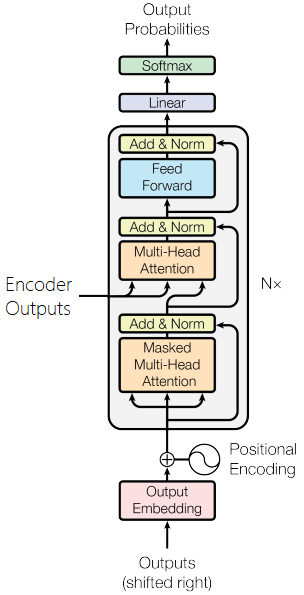

In [24]:
class Decoder(nn.Module):
  def __init__(self,
               output_dim,
               hid_dim,
               n_layers,
               n_heads,
               pf_dim,
               dropout,
               device,
               max_length=100): #here also for max 100 words pos embeddings are taken
    super().__init__()
    self.device=device
    self.tok_embedding=nn.Embedding(output_dim,hid_dim)
    self.pos_embedding = nn.Embedding(max_length,hid_dim)
    self.layers = nn.ModuleList([DecoderLayer(hid_dim,
                                              n_heads,
                                              pf_dim,
                                              dropout,
                                              device)
                                for _ in range(n_layers)])
    
    self.fc_out = nn.Linear(hid_dim,output_dim)
    self.dropout = nn.Dropout(dropout)
    self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)

  def forward(self, trg, enc_src, trg_mask, src_mask):

    #trg = [batch_size,trg_len]
    #enc_src = [batch_size,src_len,hid_dim]
    #trg_mask = [batch_size,1,trg_len,trg_len]
    #src_mask = [batch_size,1,1,src_len]

    batch_size=trg.shape[0]
    trg_len=trg.shape[1]

    pos=torch.arange(0,trg_len).unsqueeze(0).repeat(batch_size,1).to(self.device)
    #pos =[batch_size,trg_len]

    trg = self.dropout((self.tok_embedding(trg)*self.scale)+self.pos_embedding(pos))
    #trg = [batch size, trg len, hid dim]

    for layer in self.layers:
      trg,attention=layer(trg,enc_src,trg_mask,src_mask)
      #trg=[batch_size,trg_len,hid_dim]
      #attention=[batch_size,n_heads,trg_len,src_len]

    output=self.fc_out(trg)

    return output,attention

In [25]:
class DecoderLayer(nn.Module):
  def __init__(self,
              hid_dim,
              n_heads,
              pf_dim,
              dropout,
              device):
    super().__init__()
    self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
    self.enc_attn_layer_norm  = nn.LayerNorm(hid_dim)
    self.ff_layer_norm = nn.LayerNorm(hid_dim)
    self.self_attention = MultiHeadAttentionLayer(hid_dim,n_heads,dropout,device)
    self.encoder_attention = MultiHeadAttentionLayer(hid_dim,n_heads,dropout,device)
    self.positionwise_feedforward =PositionwiseFeedforwardLayer(hid_dim,pf_dim,dropout)
    self.dropout=nn.Dropout(dropout)

  def forward(self,trg, enc_src, trg_mask,src_mask):

    #trg=[batch size, trg len, hid dim]
    #enc_src=[batch_size,src_len,hid_dim]
    #trg_mask = [batch_size,1,trg_len,trg_len]
    #src_mask = [batch_size,1,1,src_len]

    #self_attention
    _trg,_ = self.self_attention(trg,trg,trg,trg_mask)

    trg = self.self_attn_layer_norm(trg+self.dropout(_trg))
    #trg =[batch_size,trg_len,hid_dim]

    #encoder_attention
    _trg,attention = self.encoder_attention(trg,enc_src,enc_src,src_mask) #attention op from last MultiHeadAttention of decoder

    trg=self.enc_attn_layer_norm(trg+self.dropout(_trg))
    #trg = [batch_size,trg_len,hid_dim]

    #positionwise feedforward

    _trg = self.positionwise_feedforward(trg)

    trg=self.ff_layer_norm(trg + self.dropout(_trg))
    #trg = [batch size, trg len, hid dim]
    #attention = [batch size, n heads, trg len, src len]
    return trg,attention #attention is returned as we can plot it later to observe how may attention is paid by ip to op sentences


In [26]:
# a=torch.tensor([[1,2],[3,4],[5,6],[7,8]])
# mask=(a!=2)
# print(mask)
# a=a.masked_fill(mask==0,3)
# a.dim()

In [27]:
class Seq2Seq(nn.Module):
  def __init__(self,
               encoder,
               decoder,
               src_pad_idx,
               trg_pad_idx,
               device):
    super().__init__()

    self.encoder=encoder
    self.decoder = decoder
    self.src_pad_idx = src_pad_idx
    self.trg_pad_idx = trg_pad_idx
    self.device = device

  def make_src_mask(self,src):
    #src=[batch_size,src_len]
    src_mask=(src!=self.src_pad_idx).unsqueeze(1).unsqueeze(2)

    #src_mask=[batch_size,1,1,src_len]

    return src_mask

  def make_trg_mask(self,trg):
    #trg=[batch_size,trg_len]

    trg_pad_mask=(trg!=self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
    #trg_pad_mask=[batch_size,1,1,trg_len]

    trg_len=trg.shape[1]
    trg_sub_mask=torch.tril(torch.ones((trg_len,trg_len),device=self.device)).bool()

    #trg_sub_mask=[trg_len,trg_len]

    trg_mask= trg_pad_mask & trg_sub_mask
    #trg_mask =[batch_size,1,trg_len,trg_len]

    return trg_mask

  def forward(self,src,trg):

    #src=[batch_size,src_len]
    #trg=[batch_size,trg_len]

    src_mask=self.make_src_mask(src)
    trg_mask=self.make_trg_mask(trg)

    #src_mask = [batch size, 1, 1, src len]
    #trg_mask = [batch size, 1, trg len, trg len]

    enc_src=self.encoder(src,src_mask)
    #enc_src=[batch_size,src_len,hid_dim]

    output,attention=self.decoder(trg, enc_src, trg_mask, src_mask)

    #output=[batch_size,trg_len,output_dim]
    #attention=[batch_size,n_heads,trg_len,src_len]

    return output, attention

In [28]:
INPUT_DIM=len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
HID_DIM=256
ENC_LAYERS=3
DEC_LAYERS=3
ENC_HEADS=8
DEC_HEADS=8
ENC_PF_DIM=512
DEC_PF_DIM=512
ENC_DROPOUT=0.1
DEC_DROPOUT=0.1

enc=Encoder(INPUT_DIM,
            HID_DIM,
            ENC_LAYERS,
            ENC_HEADS,
            ENC_PF_DIM,
            ENC_DROPOUT,
            device)

dec=Decoder(OUTPUT_DIM,
            HID_DIM,
            DEC_LAYERS,
            DEC_HEADS,
            DEC_PF_DIM,
            DEC_DROPOUT,
            device)

In [29]:
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

In [30]:
def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 9,038,853 trainable parameters


In [31]:
# model

### Xavier Weight Initialization

In [32]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:  # hasaatr: to check if an object has the given named attribute and return true if present, else false.
        nn.init.xavier_uniform_(m.weight.data)

In [33]:
model.apply(initialize_weights)

Seq2Seq(
  (encoder): Encoder(
    (tok_embedding): Embedding(7855, 256)
    (pos_embedding): Embedding(100, 256)
    (layers): ModuleList(
      (0): EncoderLayer(
        (self_attn_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (ff_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (self_attention): MultiHeadAttentionLayer(
          (fc_q): Linear(in_features=256, out_features=256, bias=True)
          (fc_k): Linear(in_features=256, out_features=256, bias=True)
          (fc_v): Linear(in_features=256, out_features=256, bias=True)
          (fc_o): Linear(in_features=256, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (positionwise_feedforward): PositionwiseFeedforwardLayer(
          (fc_1): Linear(in_features=256, out_features=512, bias=True)
          (fc_2): Linear(in_features=512, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
     

The optimizer used in original attention paper is adam with varying learning rate including warm up and cool down .Follwing r the lines from paper:

`We used the Adam optimizer (cite) with β_1 = 0.9, β_2 = 0.98, ϵ=10^−9.We varied the learning rate over the course of training, according to the formula:`

`lrate=d_model^-0.5 . min(step_num^-0.5,step_num * warmup_steps^-1.5).This corresponds to increasing the learning rate linearly for the first warmup_steps
training steps, and decreasing it thereafter proportionally to the inverse square root of the step number. We used warmup_steps=4000`

but BERT and other transformer model uses adam with fixed learning rate in this bk also will use the same.

In [34]:
LEARNING_RATE = 0.0005

optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

In [35]:
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX) #as while caculating loss only trg_pad_idx is considered

In [36]:
def train(model,iterator,optimizer,criterion,clip):
  model.train()
  epoch_loss=0

  for i,batch in enumerate(iterator):
    src=batch.src
    trg=batch.trg
    optimizer.zero_grad()
    output,_=model(src,trg[:,:-1])
    #output=[batch_size,trg_len-1,output_dim]
    #trg=[batch_size,trg_len]
    output_dim=output.shape[-1]
    output=output.contiguous().view(-1,output_dim)  #since nn.crossentropyloss expects output size=(N,C) and label size=(C) 
    trg=trg[:,1:].contiguous().view(-1)
    #output=[batch size * trg len - 1, output dim]
    #trg=[batch size * trg len - 1]
    loss=criterion(output,trg)
    loss.backward()
    torch.nn.utils.clip_grad_norm(model.parameters(),clip)
    optimizer.step()
    epoch_loss += loss.item()
    
  return epoch_loss/len(iterator)


In [37]:
def evaluate(model, iterator, criterion):
  model.eval()
  epoch_loss = 0
  with torch.no_grad():
    for i,batch in enumerate (iterator):
      src=batch.src
      trg=batch.trg
      output, _ = model(src,trg[:,:-1])
      #output = [batch_size,trg_len-1,output dim]
      #trg = [batch_size, trg_len]

      output_dim =output.shape[-1]
      output=output.contiguous().view(-1,output_dim)
      trg =trg[:,1:].contiguous().view(-1)
      #output = [batch_size*trg len - 1, output dim]
      #trg = [batch_size*trg_len-1]
      loss=criterion(output,trg)
      epoch_loss+=loss.item()
  return epoch_loss/len(iterator)

In [38]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [39]:
N_EPOCHS=10
CLIP=1
best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
  start_time = time.time()
  train_loss = train(model,train_iterator,optimizer,criterion,CLIP)
  valid_loss = evaluate(model,valid_iterator,criterion)

  end_time = time.time()
  epoch_mins,epoch_secs=epoch_time(start_time,end_time)

  if valid_loss < best_valid_loss:
    best_valid_loss = valid_loss
    torch.save(model.state_dict(),'tut6-model.pt')

  print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
  print(f'\tTrainLoss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
  print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


Epoch: 01 | Time: 0m 16s
	TrainLoss: 4.219 | Train PPL:  67.974
	 Val. Loss: 3.031 |  Val. PPL:  20.727
Epoch: 02 | Time: 0m 16s
	TrainLoss: 2.828 | Train PPL:  16.910
	 Val. Loss: 2.316 |  Val. PPL:  10.138
Epoch: 03 | Time: 0m 16s
	TrainLoss: 2.238 | Train PPL:   9.376
	 Val. Loss: 1.972 |  Val. PPL:   7.184
Epoch: 04 | Time: 0m 16s
	TrainLoss: 1.883 | Train PPL:   6.573
	 Val. Loss: 1.799 |  Val. PPL:   6.042
Epoch: 05 | Time: 0m 16s
	TrainLoss: 1.639 | Train PPL:   5.149
	 Val. Loss: 1.713 |  Val. PPL:   5.547
Epoch: 06 | Time: 0m 16s
	TrainLoss: 1.450 | Train PPL:   4.262
	 Val. Loss: 1.653 |  Val. PPL:   5.224
Epoch: 07 | Time: 0m 16s
	TrainLoss: 1.295 | Train PPL:   3.651
	 Val. Loss: 1.625 |  Val. PPL:   5.080
Epoch: 08 | Time: 0m 16s
	TrainLoss: 1.165 | Train PPL:   3.206
	 Val. Loss: 1.627 |  Val. PPL:   5.091
Epoch: 09 | Time: 0m 16s
	TrainLoss: 1.056 | Train PPL:   2.875
	 Val. Loss: 1.632 |  Val. PPL:   5.115
Epoch: 10 | Time: 0m 16s
	TrainLoss: 0.961 | Train PPL:   2.615


In [40]:
model.load_state_dict(torch.load('tut6-model.pt'))
test_loss = evaluate(model, test_iterator, criterion)
print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 1.673 | Test PPL:   5.327 |


In [41]:
def translate_sentence(sentence,src_field,trg_field,model,device,max_len=50):
  model.eval()
  if isinstance(sentence, str):
    nlp=spacy.load('de')
    tokens = [token.text.lower() for token in nlp(sentence)]
  else:
    tokens=[token.lower() for token in sentence]

  #adding sos and eos token to tokens
  tokens = [src_field.init_token] + tokens + [src_field.eos_token]

  #converting tokens to indexes 
  src_indexes=[src_field.vocab.stoi[token] for token in tokens]
  src_tensor= torch.LongTensor(src_indexes).unsqueeze(0).to(device)
  src_mask=model.make_src_mask(src_tensor)
  with torch.no_grad():
    enc_src=model.encoder(src_tensor,src_mask)

  trg_indexes=[trg_field.vocab.stoi[trg_field.init_token]]

  for i in range(max_len):
    trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)
    trg_mask =model.make_trg_mask(trg_tensor)
    with torch.no_grad():
      output,attention=model.decoder(trg_tensor,enc_src,trg_mask,src_mask)
      pred_token=output.argmax(2)[:,-1].item()
      trg_indexes.append(pred_token)

      if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
        break

  trg_tokens=[trg_field.vocab.itos[i] for i in trg_indexes]

  return trg_tokens[1:],attention

In [42]:
def display_attention(sentence,translation,attention,n_heads=8,n_rows=4,n_cols=2):
  assert n_rows*n_cols == n_heads
  fig = plt.figure(figsize=(15,25))
  for i in range(n_heads):
    ax=fig.add_subplot(n_rows,n_cols,i+1)
    _attention=attention.squeeze(0)[i].cpu().detach().numpy()
    cax=ax.matshow(_attention,cmap='bone')
    ax.tick_params(labelsize=12)
    ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'],rotation=45)
    ax.set_yticklabels(['']+translation)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

src = ['ein', 'mann', 'liegt', 'auf', 'der', 'bank', ',', 'an', 'die', 'auch', 'ein', 'weißer', 'hund', 'angebunden', 'ist', '.']
trg = ['a', 'man', 'lays', 'on', 'the', 'bench', 'to', 'which', 'a', 'white', 'dog', 'is', 'also', 'tied', '.']
predicted trg = ['a', 'man', 'laying', 'on', 'the', 'bench', ',', 'including', 'a', 'white', 'dog', 'is', 'about', 'to', 'him', '.', '<eos>']


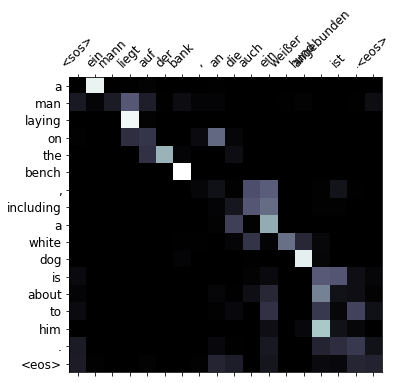

In [43]:
example_idx = 17

src = vars(train_data.examples[example_idx])['src']
trg = vars(train_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

display_attention(src, translation, attention)

In [45]:
from torchtext.data.metrics import bleu_score

def calculate_bleu(data,src_field,trg_field,model,device,max_len=50):
  trgs=[]
  pred_trgs=[]

  for datum in data:
    src=vars(datum)['src']
    trg=vars(datum)['trg']

    pred_trg,_ = translate_sentence(src,src_field,trg_field,model,device,max_len)

    #cut off <eos> token
    pred_trg=pred_trg[:-1]
    pred_trgs.append(pred_trg)
    trgs.append([trg])

  return bleu_score(pred_trgs, trgs)

In [46]:
bleu_score = calculate_bleu(test_data, SRC, TRG, model, device)

print(f'BLEU score = {bleu_score*100:.2f}')

BLEU score = 35.25
